In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import linalg as LA

#from load_data_mongoloids import load_data_mongoloids
#from mongoloids_config import config

#from load_data_cancer import load_data_cancer
#from cancer_config import config
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
#import plotly.plotly as py
import textwrap
import scipy.stats as stats

from sklearn import svm, datasets
from scipy import stats
from sklearn import neighbors, ensemble, linear_model, neural_network
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy
from functools import partial

from infrastructure.configuration import param
import matplotlib.pylab as pylab
import seaborn
seaborn.set_style('darkgrid', {'legend.frameon':True})
fontsize = 20
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'font.size':fontsize}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize)

plt.style.use('ggplot')
%matplotlib inline

import igraph
import cairo
from tqdm import tqdm
import pandas as pd

In [2]:
#from configurations.load_data_down_GSE52588 import load_data_down_GSE52588
#from configurations.config_down_GSE52588 import config

from configurations.load_data_down_GSE52588 import load_data_down_GSE52588_cpgs
from configurations.config_down_GSE52588_cpg import config

#from configurations.load_data_down_GSE131752 import load_data_down_GSE131752
#from configurations.config_down_GSE131752 import config

In [3]:
# Check that all cpgs included in loader!!! (all_cpg_names)
X, y, mask, all_cpg_names = load_data_down_GSE52588_cpgs()

Data loaded:  36.782965700000005
float32 (422802, 87)
(87, 422802)
(87, 422802) 422801 (87,) (422802,)


In [ ]:
X, y, mask, all_cpg_names, age = load_data_down_GSE131752()

In [4]:
X.shape

(87, 422801)

In [4]:
from annotations.cpgs import cpgs_annotation
cpgs = cpgs_annotation(config.ifname('cpgs_annotations'))

In [5]:
bad_cpgs = np.loadtxt(config.ifname('bad_cpgs'), dtype='str')

In [6]:
group_names = ["DS", "Siblings", "Mothers"]
groups = ["mongoloids_mask", "siblings_mask", "mothers_mask"]
group_masks = [0] * 3
for j, group_name in enumerate(groups):
    group_masks[j] = config.params[group_name].value
        

In [7]:
patients_info = pd.read_csv(config.ifname("patients_info"), delimiter='\t')
group_names = ["Classical WS", "Control"]
groups = ["classical WS", "control"]
group_masks = [0] * len(groups)
for j, group_name in enumerate(groups):
    group_masks[j] = np.flatnonzero((patients_info["group"] == group_name))

In [108]:

def calc_epimutations(X, group_masks):
    epimutations_sum = np.zeros((X.shape[0], ), dtype = np.int32)
    epimutations = np.zeros((X.shape[0], X.shape[1]), dtype = np.bool)
    for i in tqdm(range(X.shape[1]), ncols = 100):
        for j, mask in enumerate(group_masks):
            x = X[mask, i]
            q = np.quantile(x, [0.25, 0.75])
            iqr = q[1] - q[0]
            q[0] -= iqr * 3
            q[1] += iqr * 3
            epimutations[mask, i] = ((x > q[1]) | (x < q[0]))
            epimutations_sum[mask] += ((x > q[1]) | (x < q[0])).astype('int32')
    return epimutations_sum, epimutations

epimutations_sum, epimutations = calc_epimutations(X, group_masks)
epimutations_sum_r, epimutations_r = calc_epimutations(X_r, group_masks)
epimutations_sum_r2, epimutations_r2 = calc_epimutations(X_r2, group_masks)

100%|█████████████████████████████████████████████████████| 422801/422801 [03:03<00:00, 2309.52it/s]


# Trverse chromosome

In [15]:
def traverse_chromosomes(features_names, bad_cpgs, path_kernel_geotype, kernel):
    df = cpgs.get_sub_frame({'gene_out': [np.NaN], 
                             'cpgs_in': features_names, 
                             'cpgs_out': bad_cpgs})
    chromosomes = df.CHR.unique()

    ids = np.argsort(list(map(lambda x: "0" + x if len(x) == 1 and x[0].isdigit() else x, chromosomes)))
    chromosomes = chromosomes[ids]
    from matplotlib.backends.backend_pdf import PdfPages
    
    with PdfPages(path_kernel_geotype) as pdf:
        for chromosome in tqdm(chromosomes, ncols = 100):
            cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 
                                             'cpgs_in': features_names, 
                                             'chr_in': chromosome, 
                                             'cpgs_out': bad_cpgs})
            cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
            
            kernel(ids, "Chromosome: " + chromosome)
            
            pdf.savefig()
            plt.savefig(path_kernel_geotype + "_" + chromosome + ".png")
            plt.close()
            #break

# Traverse geo type

In [16]:
def traverse_geo_types(features_names, bad_cpgs, path_kernel_geotype, kernel):
    geotypes = cpgs.get_crit_col_values('geotype', {'gene_out': [np.NaN], 
                                                    'cpgs_in': features_names, 
                                                    'cpgs_out': bad_cpgs, 
                                                    'geotype_out': [np.NaN], 
                                                    'chr_out': ['X', 'Y']})
    geotypes.sort()
    geotypes.append(np.NaN)
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages(path_kernel_geotype) as pdf:
        for geotype in tqdm(geotypes, ncols = 100):
            cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 
                                             'cpgs_in': features_names, 
                                             'geotype_in': [geotype], 
                                             'cpgs_out': bad_cpgs, 
                                             'chr_out': ['X', 'Y']})
            cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
            
            kernel(ids, "Geotype: " + str(geotype))
            
            pdf.savefig()
            plt.savefig(path_kernel_geotype + "_" + str(geotype) + ".png")
            plt.close()
            #break

# Traverse gene part

In [17]:
def traverse_gene_parts(features_names, bad_cpgs, path_kernel_genepart, kernel):
    geneparts = cpgs.get_crit_col_values('genepart', {'gene_out': [np.NaN], 
                                                      'cpgs_in': features_names, 
                                                      'cpgs_out': bad_cpgs, 
                                                      'genepart_out': [np.NaN], 
                                                      'chr_out': ['X', 'Y']})
    geneparts.sort()
    from matplotlib.backends.backend_pdf import PdfPages
    
    with PdfPages(path_kernel_genepart) as pdf:
        for genepart in tqdm(geneparts, ncols = 100):
            cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 
                                             'cpgs_in': features_names, 
                                             'genepart_in': [genepart], 
                                             'cpgs_out': bad_cpgs, 
                                             'chr_out': ['X', 'Y']})
            cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
            
            kernel(ids, "Genepart: " + genepart)
            
            pdf.savefig()
            plt.savefig(path_kernel_genepart + "_" + genepart + ".png")
            plt.close()
            #break

# Traverse cpg list

In [18]:
def calc_for_cpg_list(cpgs_in, bad_cpgs, path_kernel, kernel, title = ''):
    from matplotlib.backends.backend_pdf import PdfPages
    
    with PdfPages(path_kernel) as pdf:
        cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 
                                         'cpgs_in': cpgs_in, 
                                         'cpgs_out': bad_cpgs, 
                                         'chr_out': ['X', 'Y']}) 
        cpgs_names, ids, ids2 = np.intersect1d(all_cpg_names, cpgs_names, return_indices = True)

        kernel(ids, title)

        pdf.savefig()
        plt.savefig(path_kernel + ".png")
        plt.close()
        #break

In [19]:
'''
def kernel_epimutations(ids, title, groups = groups, y = y, epimutations = epimutations):
    sub_epimutations_sum = epimutations[:, ids].astype('int32').sum(axis = 1)
    plot_epimutations(sub_epimutations_sum, groups, y, '', title = title)

def kernel_epimutations_boxplot(ids, title, groups = groups, y = y, epimutations = epimutations):
    sub_epimutations_sum = epimutations[:, ids].astype('int32').sum(axis = 1)
    plot_epimutations_boxplot(sub_epimutations_sum, groups, y, '', title = title)
'''    
def kernel_variance(ids, title, X = X, group_masks = group_masks, groups = groups):
    sd = variance_analyze(X, ids, group_masks)
    plot_variance(sd, groups, group_masks, y, title)

def kernel_variance_boxplot(ids, title, X = X, group_masks = group_masks, groups = groups):
    sd = variance_analyze(X, ids, group_masks)
    plot_variance_boxplot(sd, groups, group_masks, y, title)

'''
def kernel_variance_r(ids, title, X = X_r, group_masks = group_masks, groups = groups):
    sd = variance_analyze(X, ids, group_masks)
    plot_variance(sd, groups, group_masks, y, title)
    
def kernel_variance_r2(ids, title, X = X_r2, group_masks = group_masks, groups = groups):
    sd = variance_analyze(X, ids, group_masks)
    plot_variance(sd, groups, group_masks, y, title)        
'''

'\ndef kernel_variance_r(ids, title, X = X_r, group_masks = group_masks, groups = groups):\n    sd = variance_analyze(X, ids, group_masks)\n    plot_variance(sd, groups, group_masks, y, title)\n    \ndef kernel_variance_r2(ids, title, X = X_r2, group_masks = group_masks, groups = groups):\n    sd = variance_analyze(X, ids, group_masks)\n    plot_variance(sd, groups, group_masks, y, title)        \n'

In [20]:
def get_cpgs(input_type = 1, fname = '', col_name = 'nameCpG'):
    global cached_cpgs
    try:
        cached_cpgs
    except:
        cached_cpgs = dict()
    try:
        cached_cpgs[fname]
    except:
        df = pd.read_csv(fname, sep = '\t')
        cached_cpgs[fname] = df[col_name].values
    return cached_cpgs[fname]
    
def get_down_related_2015_cpgs(input_type = 1):
    global down_related_2015_cpgs
    try:
        down_related_2015_cpgs
    except:
        df = pd.read_csv(config.ifname('down_related_2015_cpgs'))
        down_related_2015_cpgs = df['ID_REF_Best_CpG'].values
    return down_related_2015_cpgs

def var_diff_p(x, y):
    F = x.var() / y.var()
    p_value = scipy.stats.f.cdf(F, len(x) - 1, len(y) - 1)
    return p_value # True : Reject the null hypothesis that Var(X) == Var(Y)
        

def make_std_related(X, features_names = all_cpg_names, group_masks = group_masks):
    diff_p = [np.zeros((X.shape[1], ), dtype = np.bool) for i in range(3)]
    for i in tqdm(range(X.shape[1]), ncols = 100):
        cur = X[:, i]
        diff_p[0][i] = var_diff_p(cur[group_masks[0]], cur[group_masks[1]])
        diff_p[1][i] = var_diff_p(cur[group_masks[1]], cur[group_masks[2]])
        diff_p[2][i] = var_diff_p(cur[group_masks[0]], cur[group_masks[2]])
    return diff_p
    

#diff_p = make_std_related(X, group_masks = group_masks)
#diff_p_r = make_std_related(X_r, group_masks = group_masks)
#diff_p_r2 = make_std_related(X_r2, group_masks = group_masks)

def get_std_related(input_type = 1, features_names = all_cpg_names, num_cpgs = 1000):
    global diff_p, diff_p_r, diff_p_r2
    if input_type == 1:
        cur = diff_p
    if input_type == 2:
        cur = diff_p_r
    if input_type == 3:
        cur = diff_p_r2
    ids = np.unique([np.argsort(cur[0])[-num_cpgs:], np.argsort(cur[1])[-num_cpgs:], np.argsort(cur[2])[-num_cpgs:]])
    return features_names[ids]

In [38]:
np.savez_compressed(config.ifname("var_diff_pv"), diff_p = diff_p, diff_p_r = diff_p_r, diff_p_r2 = diff_p_r2)

In [75]:
np.all(X == X_r)

False

In [62]:
path_cpgs_age_M = config.ofname([["age_related"], ["GSE87571_1000cpg_age_dependence_sigma2_test_M"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_F = config.ofname([["age_related"], ["GSE87571_1000cpg_age_dependence_sigma2_test_F"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_Igor = config.ofname([["age_related"], ["cpgs_variance"]], ext = ".txt", include_set = config.params_sets["age_related"])

#get_cpgs(fname = path_cpgs_age_Igor, col_name = 'nameCpG')

In [53]:
sd = variance_analyze(X, range(X.shape[1]), group_masks)

In [54]:
var = [0, 0, 0]
var[0] = sd[0] ** 2
var[1] = sd[1] ** 2
var[2] = sd[2] ** 2

In [57]:
var[0], var[1], var[2]
sd[0], sd[1], sd[2]

(array([0.05766241, 0.00658216, 0.02577584, ..., 0.03810199, 0.03238373,
        0.00308951], dtype=float32),
 array([0.05097779, 0.00699519, 0.01343124, ..., 0.02412374, 0.02362443,
        0.00340381], dtype=float32),
 array([0.06722929, 0.00585764, 0.00906403, ..., 0.01885523, 0.01574338,
        0.00195613], dtype=float32))

In [ ]:
for cid in ids[-10:]:
    plt.figure()
    plt.scatter(np.ones(29), X[group_masks[0], cid] - X[group_masks[0], cid].mean(), c = 'r')
    plt.scatter(np.ones(29) * 2, X[group_masks[1], cid] - X[group_masks[1], cid].mean(), c = 'g')
    plt.scatter(np.ones(29) * 3, X[group_masks[2], cid] - X[group_masks[2], cid].mean(), c = 'b')
    #plt.legend(["Down", "Siblings", "Mothers"], framealpha=0.9, fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
    #           ncol=3, mode="expand", borderaxespad=0., handletextpad=0.3, scatterpoints=1)    
    plt.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.95)
    #plt.title(str(is_diff[0][cid]) + ' ' + str(is_diff[1][cid]) + ' ' + str(is_diff[2][cid]))

In [23]:
path_cpgs_age_M = config.ofname([["age_related"], ["GSE87571_1000cpg_age_dependence_sigma2_test_M"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_F = config.ofname([["age_related"], ["GSE87571_1000cpg_age_dependence_sigma2_test_F"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_Igor = config.ofname([["age_related"], ["cpgs_variance"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_age_Igor_2 = config.ofname([["age_related"], ["sex_specific_variance_GSE87571"]], ext = ".txt", include_set = config.params_sets["age_related"])
path_cpgs_slieker_2016 = config.ofname([["age_related"], ["slieker_2016"]], ext = ".txt", include_set = config.params_sets["age_related"])

is_regressed = True

cpgs_in_subset = {'age_related_Olga_M': partial(get_cpgs, fname = path_cpgs_age_M),
                  'age_related_Olga_F': partial(get_cpgs, fname = path_cpgs_age_F),
                  'age_related_Igor': partial(get_cpgs, fname = path_cpgs_age_Igor),
                  'age_related_Igor_2019_September': partial(get_cpgs, fname = path_cpgs_age_Igor_2),
                  #'down_related_2015': get_down_related_2015_cpgs,
                  'slieker_2016': partial(get_cpgs, fname = path_cpgs_slieker_2016),
                  #'std_related': get_std_related
                 }
    
for subset_name, get_subset in tqdm(cpgs_in_subset.items()):
    path_variance = config.ofname([["variance"], ["normal"], ["variance", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["variance"])
    
    calc_for_cpg_list(get_subset(1), bad_cpgs, path_variance, kernel_variance)

    #
    if is_regressed:
        path_variance = config.ofname([["variance"], ["regressout_cells_cpg_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["variance"])
        calc_for_cpg_list(get_subset(2), bad_cpgs, path_variance, partial(kernel_variance, X = X_r))

        path_variance = config.ofname([["variance"], ["regressout_cells_age_cpg_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["variance"])
        calc_for_cpg_list(get_subset(3), bad_cpgs, path_variance, partial(kernel_variance, X = X_r2))
    
    # Boxplots
    path_variance = config.ofname([["variance"], ["normal"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                 include_set = config.params_sets["variance"])
    
    calc_for_cpg_list(get_subset(1), bad_cpgs, path_variance, kernel_variance_boxplot)

    if is_regressed:
        path_variance = config.ofname([["variance"], ["regressout_cells_cpg_variance"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["variance"])
        calc_for_cpg_list(get_subset(2), bad_cpgs, path_variance, partial(kernel_variance_boxplot, X = X_r))

        path_variance = config.ofname([["variance"], ["regressout_cells_age_cpg_variance"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["variance"])
        calc_for_cpg_list(get_subset(3), bad_cpgs, path_variance, partial(kernel_variance_boxplot, X = X_r2))
    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.48s/it]


In [49]:
path_variance

'D:\\PC\\UNN\\Science\\Gerontology\\data\\GSE52588\\params\\num_cpgs_114674\\normalization_qf\\variance\\regressout_cells_age_cpg_variance\\variance_boxplot_slieker_2016.pdf'

In [48]:
path_variance = config.ofname([["variance"], ["regressout_cells_age_cpg_variance"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["variance"])
        

'D:\\PC\\UNN\\Science\\Gerontology\\data\\GSE52588\\params\\num_cpgs_114674\\normalization_qf\\regressout_cells_age_down_cpg_variance\\variance_boxplot_slieker_2016.pdf'

In [26]:
is_epimutations_calc = False
is_variance_calc = True
is_regressed_calc = True
cpg_subsets = {'geneparts': traverse_gene_parts, 
               'geotypes': traverse_geo_types,
               'chromosomes': traverse_chromosomes}

for subset_name, traverse_subset in cpg_subsets.items():
    # Epimutation
    if is_epimutations_calc:
        path_epimutations = config.ofname([["down_epimutations"], ["epimutation", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["down_epimutations"])
        #traverse_subset(features_names, bad_cpgs, path_epimutations, kernel_epimutations)
        print(path_epimutations)

        if is_regressed_calc:
            path_epimutations = config.ofname([["regressout_cells_down_epimutations"], ["epimutation", subset_name]], ext = ".pdf", 
                                                         include_set = config.params_sets["down_epimutations"])
            #traverse_subset(features_names, bad_cpgs, path_epimutations, partial(kernel_epimutations, epimutations = epimutations_r))

            path_epimutations = config.ofname([["regressout_cells_age_down_epimutations"], ["epimutation", subset_name]], ext = ".pdf", 
                                                         include_set = config.params_sets["down_epimutations"])
            #traverse_subset(features_names, bad_cpgs, path_epimutations, partial(kernel_epimutations, epimutations = epimutations_r2))


        # Epimutation boxplots
        path_epimutation_boxplots = config.ofname([["down_epimutations"], ["epimutation_boxplot", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["down_epimutations"])
        #traverse_subset(features_names, bad_cpgs, path_epimutation_boxplots, kernel_epimutations_boxplot)

        if is_regressed_calc:
            path_epimutation_boxplots = config.ofname([["regressout_cells_down_epimutations"], ["epimutation_boxplot", subset_name]], ext = ".pdf", 
                                                         include_set = config.params_sets["down_epimutations"])
            #traverse_subset(features_names, bad_cpgs, path_epimutation_boxplots, partial(kernel_epimutations_boxplot, epimutations = epimutations_r))

            path_epimutation_boxplots = config.ofname([["regressout_cells_age_down_epimutations"], ["epimutation_boxplot", subset_name]], ext = ".pdf", 
                                                         include_set = config.params_sets["down_epimutations"])
            #traverse_subset(features_names, bad_cpgs, path_epimutation_boxplots, partial(kernel_epimutations_boxplot, epimutations = epimutations_r2))
    
    # Variance
    if is_variance_calc:
        path_variance = config.ofname([["variance"], ["normal"], ["variance", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["variance"])
        traverse_subset(all_cpg_names, bad_cpgs, path_variance, kernel_variance)

        path_variance_boxplot = config.ofname([["variance"], ["normal"], ["variance_boxplot", subset_name]], ext = ".pdf", 
                                                     include_set = config.params_sets["variance"])
        traverse_subset(all_cpg_names, bad_cpgs, path_variance_boxplot, kernel_variance_boxplot)

        if is_regressed_calc:
            path_variance = config.ofname([["variance"], ["regressout_cells_cpg_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                         include_set = config.params_sets["variance"])
            traverse_subset(all_cpg_names, bad_cpgs, path_variance, partial(kernel_variance, X = X_r))

            path_variance = config.ofname([["variance"], ["regressout_cells_age_cpg_variance"], ["variance", subset_name]], ext = ".pdf", 
                                                         include_set = config.params_sets["variance"])
            traverse_subset(all_cpg_names, bad_cpgs, path_variance, partial(kernel_variance, X = X_r2))
    
# Epimutations
'''
path_epimutations_genepart = config.ofname([["down_epimutations"], ["epimutation", "geneparts"]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
traverse_gene_parts(feature_names, bad_cpgs, path_epimutations_genepart, kernel_epimutations)

### Variance

# Genepart

path_variance_genepart = config.ofname([["down_variance"], ["variance", "geneparts"]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
traverse_gene_parts(features_names, bad_cpgs, path_variance_genepart, kernel_variance)

# 
path_epimutations_geotype = config.ofname([["down_epimutations"], ["epimutation", "geotypes"]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])

path_epimutations_chromosome = config.ofname([["down_epimutations"], ["epimutation", "chromosomes"]], ext = ".pdf", 
                                                 include_set = config.params_sets["down_epimutations"])
'''


 67%|███████████████████████████████████████████▎                     | 4/6 [00:12<00:06,  3.20s/it]

KeyboardInterrupt: 

In [25]:
path_variance

'D:\\PC\\UNN\\Science\\Gerontology\\data\\GSE52588\\params\\num_cpgs_1146740\\normalization_qf\\variance\\regressout_cells_age_cpg_variance\\variance_chromosomes.pdf'

In [ ]:
X.shape

In [33]:
from scipy import stats
#plt.boxplot([epimutations[y == 0], epimutations[y == 1], epimutations[y == 2]])
def plot_epimutations(epimutations_sum, groups, y, path_epimutations, title):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    ax = plt.axes()
    my = 0
    for j in range(len(groups)):
        x = epimutations_sum[y == j]
        kde = stats.gaussian_kde(x)
        xx = np.linspace(0, max(x) * 1.5, 300)
        yy = kde(xx)
        ax.plot(xx, yy, colors[j], alpha = 0.5, linewidth = 3)
        my = max(my, max(yy))
    
    for j in range(len(groups)):
        x = epimutations_sum[y == j]
        dy = my * 0.025
        yy = -np.random.rand(x.shape[0]) * dy * 0.8 - 2.5 * dy * j - dy
        ax.scatter(x, yy, c = colors[j], alpha = 0.5, s = 30)
        #plt.hist(x, color = colors[j], alpha = 0.5)
    #plt.xlim(left = 0)
    #ax.ticklabel_format(scilimits = [-7, 0])
    plt.legend(["Down", "Siblings", "Mothers"])
    plt.xlabel('Number of epimutations per subject\n($\\beta < Q_1 - 3 \\cdot {\\bf IQR}$ or $Q_3 + 3 \\cdot {\\bf IQR} < \\beta$)', fontsize = fontsize)
    plt.ylabel('${\\bf PDF}$', fontsize = fontsize)
    plt.title(title, fontsize = 1.2 * fontsize)
    plt.subplots_adjust(bottom=0.2, top=0.9, left=0.2, right=0.95)
    #plt.show()
    if path_epimutations != '':
        plt.savefig(path_epimutations)

def plot_epimutations_boxplot(epimutations_sum, groups, y, path_epimutations, title):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    ax = plt.axes()
    xx = []
    for j in range(len(groups)):
        x = epimutations_sum[y == j]
        xx.append(x)
        print(np.mean(x))
    
    boxprops=dict(linewidth = 0)
    capprops= whiskerprops=dict(color='#455A64', linewidth = 6)
    
    bplot = ax.boxplot(xx, labels = ["Down", "Siblings", "Mothers"], patch_artist=True, boxprops=boxprops,whiskerprops =whiskerprops, capprops =capprops )
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set(color='w', linewidth=3)
    
    for j in range(len(groups)):
        x = epimutations_sum[y == j]
        yy = j + np.random.rand(x.shape[0]) * 0.25 + 1 + 0.25
        ax.scatter(yy, x, c =  colors[j], alpha = 0.5, s = 30)
        #plt.hist(x, color = colors[j], alpha = 0.5)
    
    ax.set_yscale('log')
    #plt.xlim(left = 0)
    #ax.ticklabel_format(scilimits = [-7, 0])
    #plt.legend(["Down", "Siblings", "Mothers"], framealpha=0.9, fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
    #       ncol=3, mode="expand", borderaxespad=0., handletextpad=0.3, scatterpoints=3)    
    #plt.xlabel('Number of epimutations per subject\n($\\beta < Q_1 - 3 \\cdot {\\bf IQR}$ or $Q_3 + 3 \\cdot {\\bf IQR} < \\beta$)', fontsize = fontsize)
    plt.ylabel('Number of epimutations', fontsize = fontsize)
    plt.title(title, fontsize = 1.2 * fontsize)
    plt.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.95)
    #plt.show()
    if path_epimutations != '':
        plt.savefig(path_epimutations)
        
cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs, 'chr_out': ['X', 'Y']}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
print(len(ids))
sub_epimutations_sum = epimutations_r[:, ids].astype('int32').sum(axis = 1)
plot_epimutations_boxplot(sub_epimutations_sum, groups, y, '', 'All good cpgs on genes')

NameError: name 'features_names' is not defined

91875


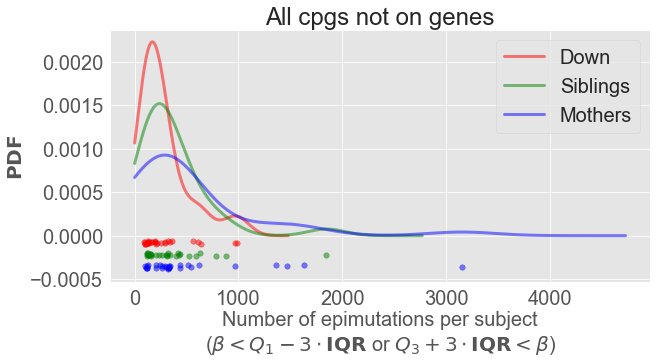

In [69]:
cpgs_names, ids = cpgs.get_cpgs({'gene_in': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
print(len(ids))
sub_epimutations_sum = epimutations[:, ids].astype('int32').sum(axis = 1)
plot_epimutations(sub_epimutations_sum, groups, y, '', 'All cpgs not on genes')

In [66]:
cpgs_names, ids = cpgs.get_cpgs({'gene_in': [np.NaN]}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']

In [68]:
len(ids)

119977

In [8]:
patients_info = pd.read_csv(config.ifname("patients_info"), delimiter='\t')

In [ ]:
group_names = ["DS", "Siblings", "Mothers"]
groups = ["mongoloids_mask", "siblings_mask", "mothers_mask"]
group_masks = [0] * 3
for j, group_name in enumerate(groups):
    group_masks[j] = config.params[group_name].value
        

std = 9.106321385694015 mean = 25.620689655172413
std = 10.71276700634451 mean = 29.82758620689655
std = 10.230052949674846 mean = 58.96551724137931


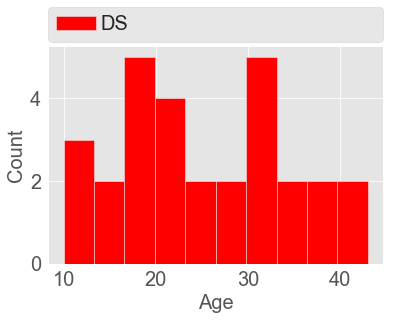

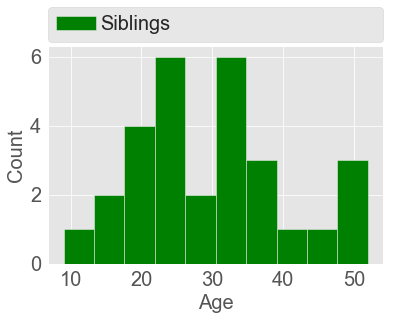

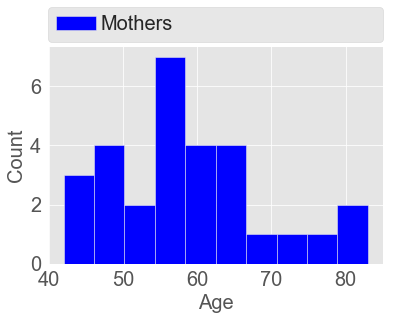

In [19]:
ages = patients_info["age"].values
colors = ['r', 'g', 'b']
for i, mask in enumerate(group_masks):
    plt.figure()
    plt.hist(ages[mask], color=colors[i])
    print('std = ' + str(ages[mask].std()) + ' mean = ' + str(ages[mask].mean()))
    #plt.title('std = ' + str(ages[mask].std()) + ' mean = ' + str(ages[mask].mean()))
    plt.xlabel('Age', fontsize = fontsize)
    plt.ylabel('Count', fontsize = fontsize)
    plt.legend([group_names[i]], framealpha=0.9, fontsize=20, #bbox_to_anchor=(0., 1.02, 1., .102), 
               bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               ncol=3, mode="expand", borderaxespad=0., handletextpad=0.2, scatterpoints=3, columnspacing = 2)
                
#plt.figure()
#plt.hist(ages[29:29*2], color='g')
#plt.figure()
#plt.hist(ages[29*2:29*3], color='b')



In [20]:
patients_info = pd.read_csv(config.ifname("patients_info"), delimiter='\t')
group_names = ["Control", "Classical WS"]
groups = ["control", "classical WS"]
group_masks = [0] * len(groups)
for j, group_name in enumerate(groups):
    group_masks[j] = np.flatnonzero((patients_info["group"] == group_name))
        

In [21]:
group_masks

[array([ 0,  2,  4,  6,  9, 11, 13, 15, 16, 18, 20, 22, 25, 27, 29, 31, 32,
        34, 36, 38, 41, 43, 45, 47], dtype=int64),
 array([ 3,  7,  8, 12, 17, 23, 24, 26, 28, 30, 33, 35, 37, 39, 40, 42, 44,
        46], dtype=int64)]

std = 11.176534818786884 mean = 35.541666666666664
std = 9.228913235380038 mean = 38.77777777777778


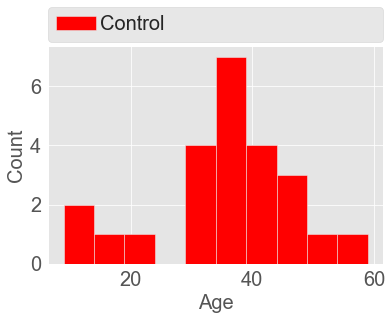

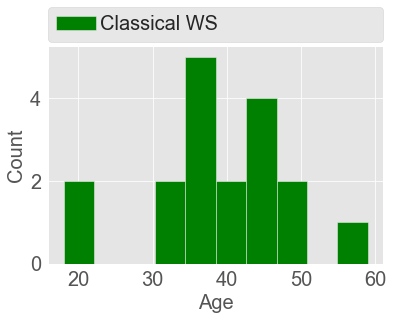

In [22]:
ages = patients_info["age"].values
colors = ['r', 'g']
for i, mask in enumerate(group_masks):
    plt.figure()
    plt.hist(ages[mask], color=colors[i])
    print('std = ' + str(ages[mask].std()) + ' mean = ' + str(ages[mask].mean()))
    #plt.title('std = ' + str(ages[mask].std()) + ' mean = ' + str(ages[mask].mean()))
    plt.xlabel('Age', fontsize = fontsize)
    plt.ylabel('Count', fontsize = fontsize)
    plt.legend([group_names[i]], framealpha=0.9, fontsize=20, #bbox_to_anchor=(0., 1.02, 1., .102), 
               bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               ncol=3, mode="expand", borderaxespad=0., handletextpad=0.2, scatterpoints=3, columnspacing = 2)
                
#plt.figure()
#plt.hist(ages[29:29*2], color='g')
#plt.figure()
#plt.hist(ages[29*2:29*3], color='b')



# CpG variance

In [9]:
def variance_analyze(X, ids, group_masks, sub_mask = None):
    if sub_mask is None:
        sub_mask = range(29)
    sd = [0] * len(group_masks)
    for j, mask in enumerate(group_masks):
        x = X[mask[:], :]
        sd[j] = np.std(x[:, ids], axis = 0)
    return sd

#sd = []

#pdf.savefig()
#plt.close()


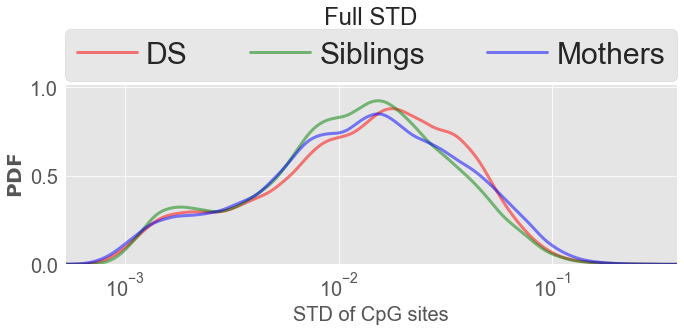

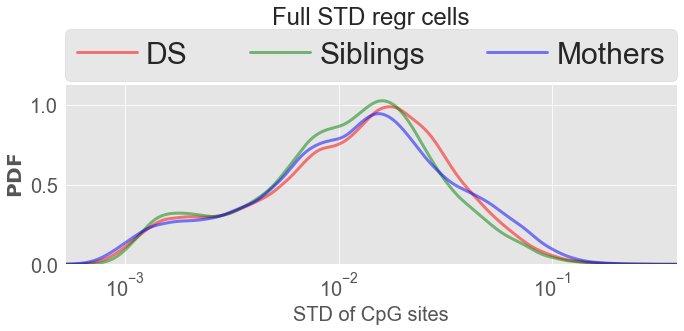

In [10]:
from scipy import stats
#plt.boxplot([epimutations[y == 0], epimutations[y == 1], epimutations[y == 2]])
def plot_changes(ax, xx, yy, colors):
    mask1 = np.logical_and(yy[0] < yy[1], yy[1] < yy[2])
    mask2 = np.logical_and(yy[0] < yy[2], yy[2] < yy[1])
    mask3 = np.logical_and(yy[1] < yy[0], yy[0] < yy[2])
    mask4 = np.logical_and(yy[1] < yy[2], yy[2] < yy[0])
    mask5 = np.logical_and(yy[2] < yy[0], yy[0] < yy[1])
    mask6 = np.logical_and(yy[2] < yy[1], yy[1] < yy[0])
    
    mask = mask1 + 2 * mask2 + 3 * mask3 + 4 * mask4 + 5 * mask5 + 6 * mask6 - 1
    pos_change = np.flatnonzero(np.diff(mask) != 0)
    print(xx[pos_change])
    
    ylim = ax.get_ylim()
    
    pos_change_x = [xx.min(), 0.0012056548995531503, 0.002596021312694869, 0.005664170799365929, 0.01506978866499511, 0.018620560297459694, 0.02661029358921901, 0.05434549, xx.max()]
    for i in range(len(pos_change_x) - 1):
        x_cur = pos_change_x[i]
        x_nxt = pos_change_x[i + 1]
        k_cur = np.flatnonzero(xx > x_cur)[0]
        k_nxt = len(xx) - 1 if i == len(pos_change_x) - 2 else np.flatnonzero(xx > x_nxt)[0]
        mk = np.argmax(np.bincount(mask[k_cur:k_nxt]))
        cx = xx[k_cur:k_nxt]
            
        id_min = 0 if mk < 2 else (2 if (mk > 3) else 1)
        id_max = 0 if mk == 3 or mk == 5 else (2 if (mk == 0 or mk == 2) else 1)
        
        cy1 = np.zeros((k_nxt - k_cur, ))
        cy2 = yy[id_min][k_cur:k_nxt]
        color = colors[id_min]
        ax.fill_between(cx, cy1, cy2, color = color, alpha = 0.5)
        
        cy1 = np.ones((k_nxt - k_cur, ))
        cy2 = yy[id_max][k_cur:k_nxt]
        color = colors[id_max]
        ax.fill_between(cx, cy1, cy2, color = color, alpha = 0.5)
        #ax.plot([x, x], [ylim[0], ylim[1]], 'k')    
    
def plot_variance(sd, groups, group_masks, y, title):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    ax = plt.axes()
    my = 0
    mn = 100
    for j, mask in enumerate(group_masks):
        if len(sd[j]) == 0: continue
        x = sd[j]
        my = max(my, max(x))
        mn = min(mn, min(x))
    
    #print([mn, my])
    #mn = 1e-3
    xx = np.linspace(np.log10(mn), np.log10(my), 500)
    yy = [[] for i in range(len(group_masks))]
    y_min = 100
    y_max = 0
    for j, mask in enumerate(group_masks):
        x = sd[j]
        kde = stats.gaussian_kde(np.log10(x))
        yy[j] = np.maximum(1e-6, kde(xx))
        ax.plot(10 ** xx, yy[j], colors[j], alpha = 0.5, linewidth = 3)
        
        ##n,x,_ = ax.hist(x, np.linspace(np.log10(mn), np.log10(my), 40), histtype=u'step', density=True, linewidth = 0)
        
        #n,x,_ = ax.hist(x, xx, cumulative = 1, histtype=u'step', density=True, linewidth = 0)
        #bin_centers = 0.5*(x[1:]+x[:-1])
        #ax.plot(bin_centers,n, linewidth = 3, c = colors[j])
    
    #plot_changes(ax, 10 ** xx, yy, colors)
    ax.set_ylim([0, np.max(yy) * 1.1])
    ax.set_xlim([0.0005241114, 0.38468492])
    
    #ax.set_yscale('log')
    ax.set_xscale('log')
    #plt.xlim(left = 0, right = my)
    #plt.ylim(bottom = 1e-5)
    #ax.ticklabel_format(scilimits = [-7, 0])
    #plt.legend(["Down", "Siblings", "Mothers"])
    #plt.subplots_adjust(bottom=0.3, top=0.95, left=0.15, right=0.95)
    legend_names = ['Down', 'Siblings', 'Mothers']
    legend_names = group_names
    plt.legend(legend_names, framealpha=0.9, fontsize=30, bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=3, mode="expand", borderaxespad=0., handletextpad=0.3, scatterpoints=3)
    plt.xlabel('STD of CpG sites', fontsize = fontsize)
    plt.ylabel('${\\bf PDF}$', fontsize = fontsize)
    plt.title(title, fontsize = 1.2 * fontsize, y = 1.3)
    plt.subplots_adjust(bottom=0.2, top=0.7, left=0.1, right=0.95)
    
    #ax.set_yscale('log')
    #plt.show()
    
def plot_variance_boxplot(sd, groups, group_masks, y, title):
    colors = ['r', 'g', 'b']
    my = 0
    
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    ax = plt.axes()
    xx = []
    for j, mask in enumerate(group_masks):
        x = sd[j]
        xx.append(x)
    
    boxprops=dict(linewidth = 0)
    capprops= whiskerprops=dict(color='#455A64', linewidth = 6)    
    bplot = ax.boxplot(xx, labels = group_names, patch_artist=True, boxprops=boxprops,whiskerprops =whiskerprops, capprops =capprops )
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set(color='w', linewidth=3)
    
    for j, mask in enumerate(group_masks):
        x = sd[j]
        yy = j + np.random.rand(x.shape[0]) * 0.25 + 1 + 0.25
        #ax.scatter(yy, x, c =  colors[j], alpha = 0.5, s = 30)
    
    ax.set_yscale('log')
    
    plt.ylabel('STD of CpG sites', fontsize = fontsize)
    plt.title(title, fontsize = 1.2 * fontsize)
    plt.subplots_adjust(bottom=0.2, top=0.9, left=0.2, right=0.95)


cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': all_cpg_names, 'cpgs_out': bad_cpgs, 'chr_out': ['X', 'Y']}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
cpgs_names, ids, ids2 = np.intersect1d(all_cpg_names, cpgs_names, return_indices = True)

#sd_ratio = [[], sd[1] / sd[0], sd[2] / sd[0]]
#plot_variance_boxplot(sd, groups, group_masks, y, 'Full STD')
sd = variance_analyze(X, ids, group_masks)
plot_variance(sd, groups, group_masks, y, 'Full STD')

'''sub_mask = list(range(28))
cid = np.random.randint(29)
sub_mask.remove(cid)
print(cid)

sd = variance_analyze(X, ids, group_masks, sub_mask = sub_mask)
plot_variance(sd, groups, group_masks, y, 'Full STD')
'''

sd = variance_analyze(X_r, ids, group_masks)
#plot_variance_boxplot(sd, groups, group_masks, y, 'Full STD')
plot_variance(sd, groups, group_masks, y, 'Full STD regr cells')

#sd = variance_analyze(X_r2, ids, group_masks)
#plot_variance_boxplot(sd, groups, group_masks, y, 'Full STD')
#plot_variance(sd, groups, group_masks, y, 'Full STD regr cells age')

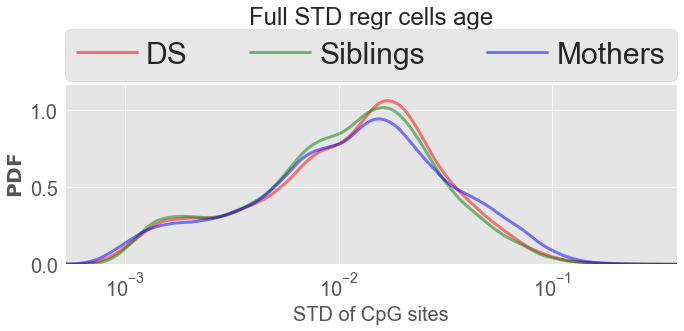

In [11]:
sd = variance_analyze(X_r2, ids, group_masks)
#plot_variance_boxplot(sd, groups, group_masks, y, 'Full STD')
plot_variance(sd, groups, group_masks, y, 'Full STD regr cells age')

In [16]:
cpgs_names, ids, ids2 = np.intersect1d(all_cpg_names, ['cg16248916', 'cg08128007'], return_indices = True)
print(cpgs_names, ids, ids2)

['cg08128007' 'cg16248916'] [ 10 100] [1 0]


In [14]:
all_cpg_names[100]

'cg16248916'

In [43]:
X.shape

(87, 114674)

In [19]:
groups

['classical WS', 'control']

In [18]:
for i in range(len(sd)):
    print(scipy.stats.skew(np.log10(sd[i])))
    print(10 ** np.mean(np.log10(sd[i])))

print(scipy.stats.ttest_ind(sd[0], sd[1]))
print(scipy.stats.ttest_ind(sd[0], sd[2]))
print(scipy.stats.ttest_ind(sd[1], sd[2]))

print(scipy.stats.ttest_ind(np.log10(sd[0]), np.log10(sd[1])))
print(scipy.stats.ttest_ind(np.log10(sd[0]), np.log10(sd[2])))
print(scipy.stats.ttest_ind(np.log10(sd[1]), np.log10(sd[2])))

0.06726843118667603
0.01743182680033388
0.019831685349345207
0.017843815821413693
Ttest_indResult(statistic=4.104003918198623, pvalue=4.0611468624568703e-05)


IndexError: list index out of range

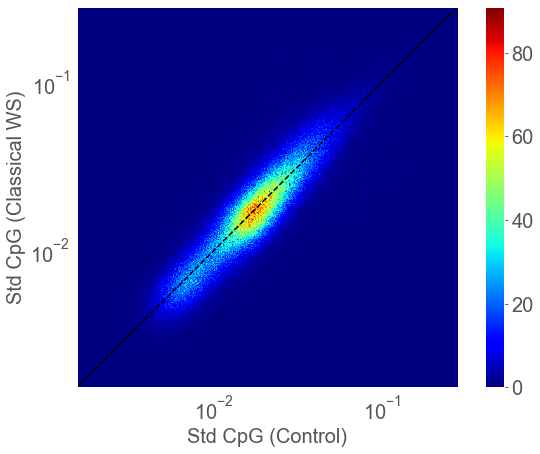

In [87]:
def plot_2d_variance_hist(sd, labels):
    nbins = 400
    bins = [np.geomspace(sd[0].min(), sd[0].max(), nbins), np.geomspace(sd[1].min(), sd[1].max(), nbins)]
    import matplotlib.pyplot as plt

    my_cmap = plt.cm.jet
    my_cmap.set_under('w', 0)

    plt.figure(figsize=(10,7))
    plt.hist2d(sd[0], sd[1], bins = bins, cmap = my_cmap)
    mx = min(sd[0].max(), sd[1].max())
    mn = max(sd[0].min(), sd[1].min())
    plt.plot([mn, mx], [mn, mx], 'k--')
    plt.xlim([mn, mx])
    plt.ylim([mn, mx])
    plt.gca().set_aspect('equal', 'box')
    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar()
    plt.xlabel('Std CpG (' + labels[0] + ')', fontsize = fontsize)
    plt.ylabel('Std CpG (' + labels[1] + ')', fontsize = fontsize)
    
cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': all_cpg_names, 'cpgs_out': bad_cpgs, 'chr_out': ['X', 'Y']}) # 'geotype_in': ['Island', 'N_Shore', 'S_Shore']
cpgs_names, ids, ids2 = np.intersect1d(all_cpg_names, cpgs_names, return_indices = True)

sd = variance_analyze(X_r2, ids, group_masks)

#plot_2d_variance_hist([sd[0], sd[1]], labels = ['DS', 'Siblings'])
#plot_2d_variance_hist([sd[0], sd[2]], labels = ['DS', 'Mothers'])
#plot_2d_variance_hist([sd[2], sd[1]], labels = ['Mothers', 'Siblings'])
plot_2d_variance_hist([sd[1], sd[0]], labels = ['Control', 'Classical WS'])

In [ ]:
def plot_diff_hist():
    

In [40]:
cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 'cpgs_in': features_names, 'cpgs_out': bad_cpgs, 'chr_out': ['X', 'Y']})
cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)
sd = variance_analyze(X, ids, group_masks)

In [13]:
df_cells = pd.read_csv(config.ifname('cells'), delimiter = '\t')
df_cells.columns

Index(['SampleID', 'DNAmAge', 'Comment', 'noMissingPerSample',
       'meanMethBySample', 'minMethBySample', 'maxMethBySample',
       'corSampleVSgoldstandard', 'meanAbsDifferenceSampleVSgoldstandard',
       'predictedGender',
       ...
       'DNAmPAI1AdjAge', 'DNAmTIMP1AdjAge', 'DNAmGrimAgeAdjAge',
       'DNAmTLAdjAge', 'IEAA', 'EEAA', 'IEAA.Hannum',
       'AgeAccelerationResidualHannum', 'AgeAccelGrim', 'AgeAccelPheno'],
      dtype='object', length=119)

In [47]:
def regress_out_cells(X, is_age):
    df_cells = pd.read_csv(config.ifname('cells'), delimiter = ',', index_col = 0)   
    
    # reindexing by sample_id
    patients_info = pd.read_csv(config.ifname("patients_info"), delimiter='\t')
    df_cells = df_cells.reindex(patients_info["sample_id"])

    from sklearn.linear_model import LinearRegression
    cells_cols = ['CD8T', 'CD4T', 'NK', 'Bcell', 'Gran']
    if is_age:
        df_cells["age"] = patients_info["age"].values
        cells_cols.append('age')
    df_sub_cells = df_cells[cells_cols]
    data = df_sub_cells.values
    return data
    
    X_r = np.array(X)
    for i in tqdm(range(len(all_cpg_names)), ncols = 100):
        beta = X[:, i]
        model = LinearRegression()
        model.fit(data, beta)
        beta_pred = model.predict(data)
        X_r[:, i] = beta - beta_pred + np.mean(beta)
    return X_r
'''
patients_info = pd.read_csv(config.ifname("patients_info"), delimiter='\t')
X_r = regress_out_cells(X, False)
X_r2 = regress_out_cells(X, True)
np.savez_compressed(config.ifname("beta_values"), X = X, X_r = X_r, X_r2 = X_r2, all_cpg_names = all_cpg_names)

data = np.load(config.ifname("beta_values"))
X = data['X']
X_r = data['X_r']
X_r2 = data['X_r2']
all_cpg_names = data['all_cpg_names']
'''

'\npatients_info = pd.read_csv(config.ifname("patients_info"), delimiter=\'\t\')\nX_r = regress_out_cells(X, False)\nX_r2 = regress_out_cells(X, True)\nnp.savez_compressed(config.ifname("beta_values"), X = X, X_r = X_r, X_r2 = X_r2, all_cpg_names = all_cpg_names)\n\ndata = np.load(config.ifname("beta_values"))\nX = data[\'X\']\nX_r = data[\'X_r\']\nX_r2 = data[\'X_r2\']\nall_cpg_names = data[\'all_cpg_names\']\n'

In [50]:
data = regress_out_cells(X, True)
data[:, -1]

array([18., 12., 13., 24., 33., 31., 19., 29., 22., 38., 34., 37., 10.,
       33., 35., 18., 16., 18., 27., 43., 33., 22., 18., 21., 32., 26.,
       43., 16., 22., 21., 22.,  9., 21., 42., 24., 25., 24., 33., 52.,
       29., 46., 32., 36., 31., 16., 21., 24., 29., 48., 52., 32., 25.,
       19., 35., 33., 38., 14., 32., 50., 51., 42., 57., 65., 56., 48.,
       51., 64., 83., 59., 76., 56., 56., 57., 46., 50., 45., 64., 82.,
       73., 60., 58., 61., 66., 60., 68., 48., 58.])

In [51]:
np.flatnonzero(all_cpg_names == 'cg06847624')[0]

131607

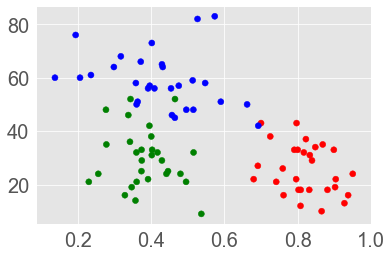

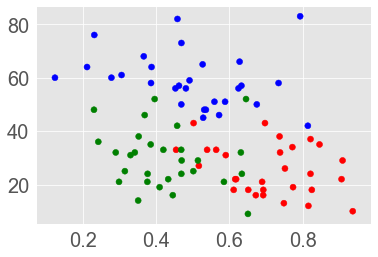

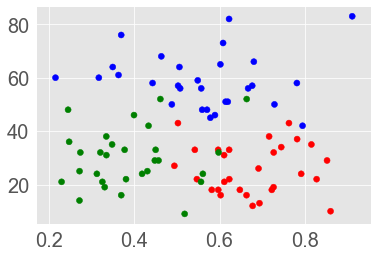

In [68]:
colors = ['r', 'g', 'b', 'c', 'y', 'm']
c = [colors[i] for i in y]
plt.figure()
plt.scatter(X[:, 131607], data[:, -1], c = c)
plt.figure()
plt.scatter(X_r[:, 131607], data[:, -1], c = c)
plt.figure()
plt.scatter(X_r2[:, 131607], data[:, -1], c = c)

In [8]:
config.ifname("beta_values")

'D:\\PC\\UNN\\Science\\Gerontology\\data\\GSE52588\\GSE52588_beta_fn.npz'

In [45]:
print(X.shape), len(all_cpg_names)

(87, 422802)


(None, 422802)

(array([3.8200000e+02, 1.0533699e+07, 3.7722750e+06, 1.9081820e+06,
        1.4537200e+06, 1.5041340e+06, 2.7676640e+06, 9.0105230e+06,
        5.8287160e+06, 4.3920000e+03]),
 array([-0.10410701,  0.01288826,  0.12988353,  0.2468788 ,  0.36387408,
         0.48086935,  0.5978646 ,  0.7148599 ,  0.8318552 ,  0.94885045,
         1.0658457 ], dtype=float32),
 <a list of 10 Patch objects>)

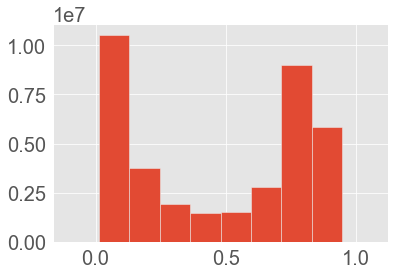

In [18]:
plt.hist(X_r2.flatten())

(array([ 6.,  7.,  5., 17., 15., 22., 11.,  2.,  1.,  1.]),
 array([0.17985177, 0.21816574, 0.2564797 , 0.2947937 , 0.33310765,
        0.37142164, 0.40973562, 0.44804958, 0.48636356, 0.5246775 ,
        0.5629915 ], dtype=float32),
 <a list of 10 Patch objects>)

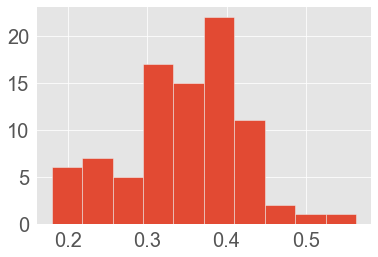

In [11]:
plt.hist(np.abs(X0[:, 0] - X[:, 0]))

In [8]:
X.shape

(87, 422801)

In [15]:
np.savez_compressed(config.ifname("beta_values"), X = X, X_r = X_r, X_r2 = X_r2)

In [65]:
df_cells.columns.values

array(['SampleID\tDNAmAge\tComment\tnoMissingPerSample\tmeanMethBySample\tminMethBySample\tmaxMethBySample\tcorSampleVSgoldstandard\tmeanAbsDifferenceSampleVSgoldstandard\tpredictedGender\tmeanXchromosome\tSampleID1\tPlasmaBlast\tCD8pCD28nCD45RAn\tCD8naive\tCD4naive\tCD8T\tCD4T\tNK\tBcell\tMono\tGran'],
      dtype=object)

(array([3.9091984e+07, 8.5363000e+05, 1.6652100e+05, 5.5377000e+04,
        2.1150000e+04, 9.5180000e+03, 4.9390000e+03, 2.1670000e+03,
        7.9600000e+02, 9.8000000e+01]),
 array([5.1186111e-11, 9.6048571e-02, 1.9209714e-01, 2.8814572e-01,
        3.8419428e-01, 4.8024285e-01, 5.7629144e-01, 6.7233998e-01,
        7.6838857e-01, 8.6443710e-01, 9.6048570e-01], dtype=float32),
 <a list of 10 Patch objects>)

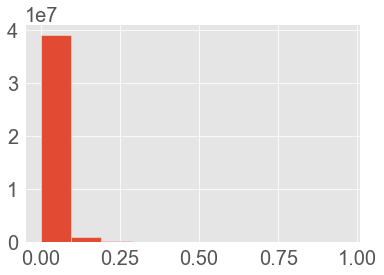

In [76]:
plt.hist(X_r.flatten())

In [83]:
df = pd.DataFrame()
df['epimutations_sum'] = sub_epimutations_sum
df.to_csv(config.ifname('epimutations'))

In [82]:
sub_epimutations_sum = epimutations[:, ids].astype('int32').sum(axis = 1)

In [57]:
def distr_less(x, y, alpha = 0.05, alternative = 'two-sided'):
    ks, p = stats.ks_2samp(x, y, alternative = alternative)
    return ks, p
for alternative in ['two-sided', 'less', 'greater']:
    print(distr_less(sd[0], sd[1], alternative = alternative))
    print(distr_less(sd[0], sd[2], alternative = alternative))
    print(distr_less(sd[1], sd[2], alternative = alternative))
    print('')
'''
print(distr_less(np.log10(sd[0]), np.log10(sd[2])))
print(distr_less(np.log10(sd[0]), np.log10(sd[1])))
print(distr_less(np.log10(sd[1]), np.log10(sd[2])))
'''

(0.03948604074863926, 5.1193269502480527e-216)
(0.03217113549063888, 1.543225409745477e-143)
(0.03217113549063888, 1.543225409745477e-143)
(0.048399609285438294, 0.0)

(0.03948604074863926, 2.4605619383268044e-216)
(0.01774861726619159, 2.7143684282782443e-44)
(0.01774861726619159, 2.7143684282782443e-44)
(0.009937466825381373, 2.190453937144936e-14)

(0.002763897220712897, 0.08759832068833201)
(0.03217113549063888, 7.471841028250168e-144)
(0.03217113549063888, 7.471841028250168e-144)
(0.048399609285438294, 0.0)



'\nprint(distr_less(np.log10(sd[0]), np.log10(sd[2])))\nprint(distr_less(np.log10(sd[0]), np.log10(sd[1])))\nprint(distr_less(np.log10(sd[1]), np.log10(sd[2])))\n'

In [43]:
print(distr_less(sd[0], sd[0]))


ks =  0.0042463511845498144 pv =  0.006422628048431702
0.006422628048431702


In [21]:
n1 = 200 
n2 = 300
rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1)
rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

Ks_2sampResult(statistic=0.21833333333333332, pvalue=1.807865352443372e-05)

In [28]:
def is_intersect(a, b):
    #if not hasattr(a, '__len__'):
    #    a = [a]
    #if not hasattr(b, '__len__'):
    #    b = [b]
    #   print a, b
    if len(a) > len(b):
        a, b = b, a
    if type(b) is set:
        return bool(b.intersection(a))
    return bool(set(a).intersection(b))
a = [1, 4, 5, 6, 'b', 'a', 1.1]
b = [2, 3, 9, np.NaN, 'c', 1.1 + 1e-15]
is_intersect(a, b), is_intersect(b, a)

(False, False)

In [36]:
def traverse_gene_parts_test(features_names, bad_cpgs):
    geneparts = cpgs.get_crit_col_values('genepart', {'gene_out': [np.NaN], 
                                                      'cpgs_in': features_names, 
                                                      'cpgs_out': bad_cpgs, 
                                                      'genepart_out': [np.NaN], 
                                                      'chr_out': ['X', 'Y']})
    geneparts.sort()
    
    for genepart in geneparts:
        cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 
                                         'cpgs_in': features_names, 
                                         'genepart_in': [genepart], 
                                         'cpgs_out': bad_cpgs, 
                                         'chr_out': ['X', 'Y']})
        cpgs_names, ids, ids2 = np.intersect1d(features_names, cpgs_names, return_indices = True)

        print(ids[0:4])
        
        
traverse_gene_parts_test(all_cpg_names, bad_cpgs)

'''
34431
16853
58015
151690
73588
55824
'''

[329495  73887  43789 224373]
[ 75649 196276 301399 224373]
[ 86175 108752  73887  43789]
[ 75649  90553 215972 390604]
[331970 195947 226496 331190]
[309076 281646  30289 226496]


'\n34431\n16853\n58015\n151690\n73588\n55824\n'

In [43]:
cpgs_in = ['cg04195702', 'cg02968844', 'cg09860601']
cpgs_names, ids = cpgs.get_cpgs({'gene_out': [np.NaN], 
                                 'cpgs_in': cpgs_in, 
                                 'cpgs_out': bad_cpgs, 
                                 'chr_out': ['X', 'Y']}) 
cpgs_names, ids, ids2 = np.intersect1d(all_cpg_names, cpgs_names, return_indices = True)
print(cpgs_names, ids)

['cg02968844' 'cg09860601'] [ 100 1000]


In [42]:
all_cpg_names[10], all_cpg_names[100], all_cpg_names[1000]

('cg04195702', 'cg02968844', 'cg09860601')